In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import gurobipy as gp#not sure this is needed
from gurobipy import GRB #not sure this is needed
import scipy.sparse as sp
import requests
import json

## Parameters

## Data Loading

In [26]:
solar = pd.read_csv('Solar_Data_Zurich.csv', header=None, names=['Solar radiation [W/m2]']) #hourly resolution, 2019
#access days from 7th of april to 11th of april 2019
start_day = 7
end_day = 11
days_before_april = 31 + 28 + 31  # Jan + Feb + Mar = 90
start_index = (days_before_april + start_day - 1) * 24
end_index = (days_before_april + end_day) * 24
solar = solar.iloc[start_index:end_index]
hourly_index = pd.date_range(start='2019-04-07', periods=120, freq='H')
solar.index = hourly_index
quarter_hourly_index = pd.date_range(start='2019-04-07', periods=480, freq='15T')
solar_interpolated = solar.reindex(quarter_hourly_index)
solar_interpolated = solar_interpolated.interpolate(method='linear') #Interpolate missing values linearly
print(solar_interpolated.shape)


(480, 1)


/var/folders/0w/44rywk3j1dl_gqy839v3wqyh0000gn/T/ipykernel_30016/498473070.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_index = pd.date_range(start='2019-04-07', periods=120, freq='H')
/var/folders/0w/44rywk3j1dl_gqy839v3wqyh0000gn/T/ipykernel_30016/498473070.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  quarter_hourly_index = pd.date_range(start='2019-04-07', periods=480, freq='15T')


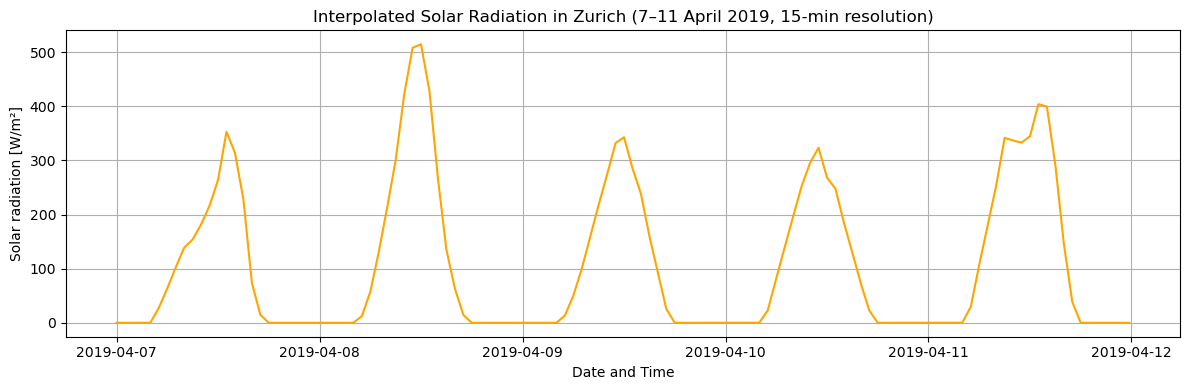

In [29]:
# Plot the interpolated 15-minute resolution data
plt.figure(figsize=(12, 4))
plt.plot(solar_interpolated.index, solar_interpolated['Solar radiation [W/m2]'], color='orange')
plt.title('Interpolated Solar Radiation in Zurich (7–11 April 2019, 15-min resolution)')
plt.xlabel('Date and Time')
plt.ylabel('Solar radiation [W/m²]')
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
solar_interpolated.head(480)

,Solar radiation [W/m2]
2019-04-07 00:00:00,0.0
2019-04-07 00:15:00,0.0
2019-04-07 00:30:00,0.0
2019-04-07 00:45:00,0.0
2019-04-07 01:00:00,0.0
...,...
2019-04-11 22:45:00,0.0
2019-04-11 23:00:00,0.0
2019-04-11 23:15:00,0.0
2019-04-11 23:30:00,0.0


In [ ]:
# Copy original irradiance values (W/m²)
irradiance_wm2 = solar_interpolated['Solar radiation [W/m2]']

# Convert to energy in kWh/m² for each 15-minute interval
energy_kwhm2 = irradiance_wm2 * 0.25 / 1000

# Create a new column or DataFrame
solar_energy = pd.DataFrame({
    'Energy [kWh/m²]': energy_kwhm2
}, index=solar_interpolated.index)

solar_energy.head(40)

,Energy [kWh/m²]
2019-04-07 00:00:00,0.000000
2019-04-07 00:15:00,0.000000
2019-04-07 00:30:00,0.000000
2019-04-07 00:45:00,0.000000
2019-04-07 01:00:00,0.000000
2019-04-07 01:15:00,0.000000
2019-04-07 01:30:00,0.000000
2019-04-07 01:45:00,0.000000
2019-04-07 02:00:00,0.000000
2019-04-07 02:15:00,0.000000


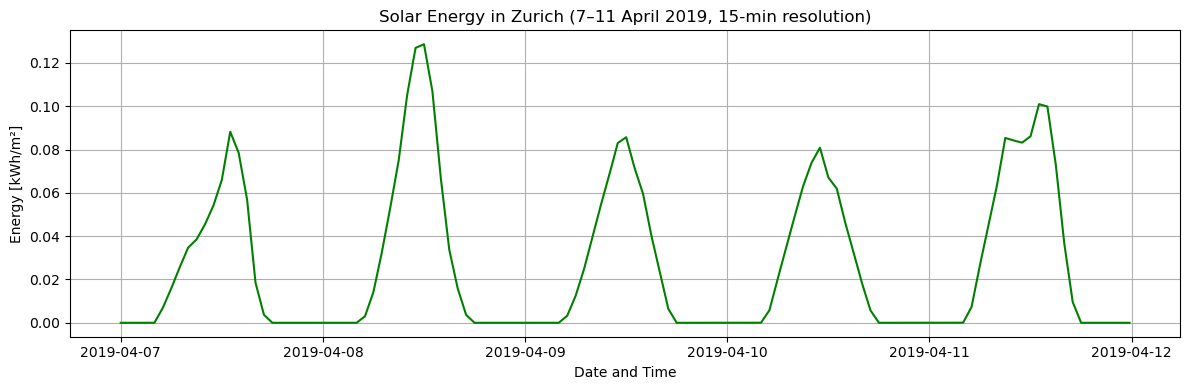

In [38]:
# Plot the solar energy (kWh/m²) at 15-minute intervals
plt.figure(figsize=(12, 4))
plt.plot(solar_energy.index, solar_energy['Energy [kWh/m²]'], color='green')
plt.title('Solar Energy in Zurich (7–11 April 2019, 15-min resolution)')
plt.xlabel('Date and Time')
plt.ylabel('Energy [kWh/m²]')
plt.grid(True)
plt.tight_layout()
plt.show()

solar_energy.to_csv('Solar_Energy_Zurich_15min.csv')

## Temperature data loading 

(480, 3)


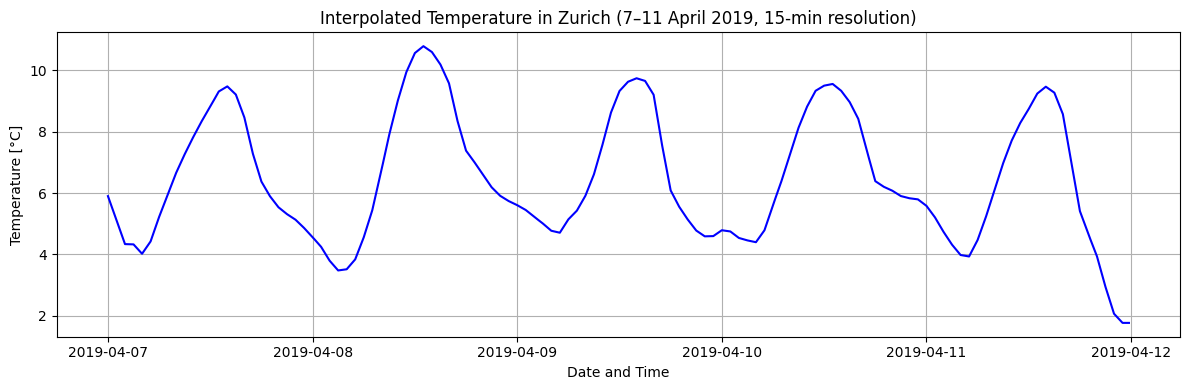

In [7]:
# Load the temperature data, skipping the 3 metadata lines
temperature = pd.read_csv('Temperature_Data_Zurich_2019.csv', header=0,skiprows=3,parse_dates=['time'])
# Rename column 't2m' to 'temperature' for clarity
temperature.rename(columns={'t2m': 'temperature'}, inplace=True)

# -- Extract days from 7th to 11th April 2019 --
start_day = 7
end_day = 11
# Calculate the days before April (Jan (31) + Feb (28) + Mar (31) = 90)
days_before_april = 31 + 28 + 31  
# Each day has 24 hourly entries
start_index = (days_before_april + start_day - 1) * 24  
end_index = (days_before_april + end_day) * 24

temperature_subset = temperature.iloc[start_index:end_index].copy()

# Set up an hourly DateTimeIndex starting at 2019-04-07 for the subset
temperature_subset.index = pd.date_range(start='2019-04-07', periods=temperature_subset.shape[0], freq='H')

# -- Interpolate to 15-minute resolution --
# Create a new 15-minute resolution index covering the same period
quarter_hourly_index = pd.date_range(start='2019-04-07', periods=4 * temperature_subset.shape[0], freq='15T')

# Reindex and interpolate linearly
temperature_interpolated = temperature_subset.reindex(quarter_hourly_index)
temperature_interpolated = temperature_interpolated.interpolate(method='linear')

print(temperature_interpolated.shape)

# Plot the interpolated temperature data
plt.figure(figsize=(12, 4))
plt.plot(temperature_interpolated.index, temperature_interpolated['temperature'], color='blue')
plt.title('Interpolated Temperature in Zurich (7–11 April 2019, 15-min resolution)')
plt.xlabel('Date and Time')
plt.ylabel('Temperature [°C]')
plt.grid(True)
plt.tight_layout()
plt.show()

# Drop the unnecessary columns ("time" and "local_time")
temperature_final = temperature_interpolated[['temperature']].copy()

# Save the DataFrame, using the index as the time column (with header "time")
temperature_final.to_csv('Temperature_Data_Zurich_15min.csv', index_label='time')

## Electricity price Loading 

In [3]:
def fetch_vario_plus_15min(start_date: str, end_date: str) -> pd.DataFrame:
    """
    Fetch Vario Plus prices at 15-minute resolution between two dates.

    Parameters
    ----------
    start_date : str
        'YYYY-MM-DD', e.g. '2019-04-07'
    end_date : str
        'YYYY-MM-DD', e.g. '2019-04-11'

    Returns
    -------
    pd.DataFrame
        Indexed by a 15-min DatetimeIndex, with a 'price' column (CHF/kWh).
    """
    base_url = 'https://api.tariffs.groupe-e.ch'
    endpoint = '/v1/tariffs/vario_plus'

    # Build ISO timestamps with CEST offset
    start_ts = f"{start_date}T00:00:00+02:00"
    end_ts   = f"{end_date}T00:00:00+02:00"

    resp = requests.get(
        base_url + endpoint,
        params={'start_timestamp': start_ts, 'end_timestamp': end_ts}
    )
    resp.raise_for_status()
    data = resp.json()

    # If wrapped inside {"prices": […]}, unwrap; otherwise assume list at top level
    if isinstance(data, dict) and 'prices' in data:
        data = data['prices']

    # Build DataFrame
    df = pd.DataFrame(data)
    # We know the JSON fields are:
    #   'start_timestamp' (timestamp), 'end_timestamp', 'vario_plus' (price), 'unit'
    df['time'] = pd.to_datetime(df['start_timestamp']).dt.tz_localize(None)
    df = df[['time', 'vario_plus']].rename(columns={'vario_plus': 'price'}).sort_values('time')
    return df



                 time  price
0 2024-04-07 00:00:00  31.14
1 2024-04-07 00:15:00  30.96
2 2024-04-07 00:30:00  30.48
3 2024-04-07 00:45:00  29.99
4 2024-04-07 01:00:00  31.02
Total 15-min points: 480


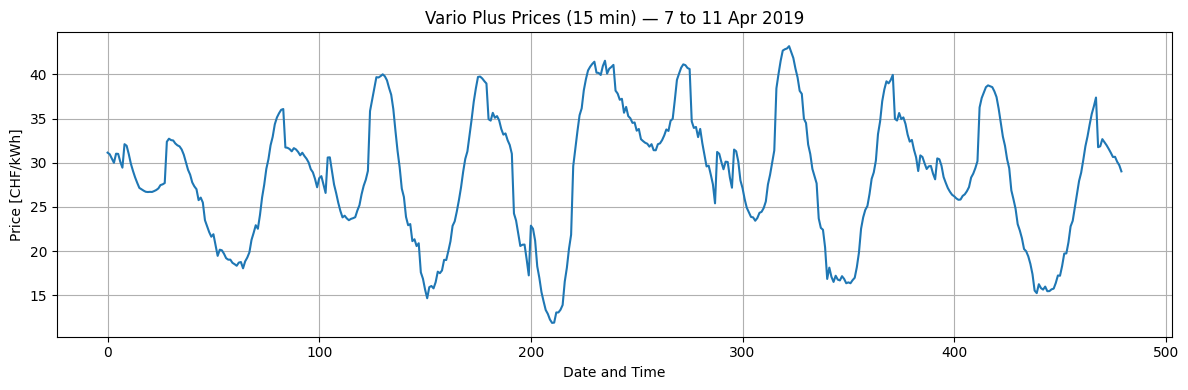

In [4]:
prices_15min = fetch_vario_plus_15min('2024-04-07','2024-04-12')

# Quick sanity check
print(prices_15min.head())
print(f"Total 15-min points: {len(prices_15min)}")

# Plot the 15-min price curve
plt.figure(figsize=(12, 4))
plt.plot(prices_15min.index, prices_15min['price'])
plt.title('Vario Plus Prices (15 min) — 7 to 11 Apr 2019')
plt.xlabel('Date and Time')
plt.ylabel('Price [CHF/kWh]')
plt.grid(True)
plt.tight_layout()
plt.show()

# Save to CSV 
prices_15min.to_csv('VarioPlus_2019-04-07_to_2019-04-11_15min.csv', index=False)
